In [30]:
import matplotlib.pyplot as plt
import numpy as np
from pyscf import ao2mo, fci, gto, mcscf, scf, tools
from qiskit.quantum_info import SparsePauliOp




In [41]:
from qiskit.quantum_info import SparsePauliOp
 
H = SparsePauliOp(["XX", "YY", "ZZ"], coeffs=[1.0 + 0.0j, 1.0 + 0.0j, 1.0 + 0.0j])
print(H)

SparsePauliOp(['XX', 'YY', 'ZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j])


In [31]:
def cholesky(V, eps):
    # see https://arxiv.org/pdf/1711.02242.pdf section B2
    # see https://arxiv.org/abs/1808.02625
    # see https://arxiv.org/abs/2104.08957
    no = V.shape[0]
    chmax, ng = 20 * no, 0
    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    print(
        "accuracy of Cholesky decomposition ",
        np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    )
    return L, ng


def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])


def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                l, r = "I" * (n - 1), ""
            elif p == n - 1:
                l, r = "", "Z" * (n - 1)
            else:
                l, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(l + "X" + r, 0.5), (l + "Y" + r, -0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list


def build_hamiltonian(ecore: float, h1e: np.ndarray, h2e: np.ndarray) -> SparsePauliOp:
    ncas, _ = h1e.shape

    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r]
                + C[ncas + p] @ D[ncas + r]
                + C[r] @ D[p]
                + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)

    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)

    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg

    return H.chop().simplify()

In [35]:
mol.build(
    verbose=0,
    atom=[
        ["N", (0.0, 0.0, 0.0)],
        ["H", (0.0, 0.937, 0.381)],
        ["H", (0.812, -0.468, 0.381)],
        ["H", (-0.812, -0.468, 0.381)],
    ],
    basis="sto-6g",
    spin=0,
    charge=0,
    symmetry=False,  # Turn off symmetry
)



In [37]:
ncas = 4
nelecas = (4, 4)
mx = mcscf.CASCI(mf, ncas=ncas, nelecas=nelecas)

E2 = mx.kernel()  # No sorting by irrep needed


In [38]:
# ----------------- Effective Hamiltonians -----------------
h1e, ecore = mx.get_h1eff()
h2e = ao2mo.restore(1, mx.get_h2eff(), mx.ncas)

# ----------------- Build Fermionic Hamiltonian -----------------
# Example build_hamiltonian function
def build_hamiltonian(ecore, h1e, h2e):
    """
    Simple Fermionic Hamiltonian in second quantization form:
    H = sum_pq h1e[p,q] a^†_p a_q + 0.5 * sum_pqrs h2e[p,q,r,s] a^†_p a^†_q a_s a_r + Ecore
    Here, we return the integral tensors; Qiskit can convert these to qubit Hamiltonian.
    """
    H = {
        "ecore": ecore,
        "h1e": h1e,
        "h2e": h2e
    }
    return H

H = build_hamiltonian(ecore, h1e, h2e)

print("CASCI Energy:", E2)
print("Hamiltonian integrals ready for QC simulation.")

CASCI Energy: (-55.98833358818831, -20.107640884641683, FCIvector([[1.]]), NPArrayWithTag([[ 9.96086575e-01, -2.09384191e-01,  0.00000000e+00,
                  8.41438531e-05, -8.26859327e-02, -1.69395865e-01,
                 -4.82869957e-04,  2.26111857e-15],
                [ 2.00321849e-02,  7.37639834e-01,  0.00000000e+00,
                 -4.21093677e-04,  4.44798456e-01,  1.26959917e+00,
                  3.80977142e-03, -1.69359901e-14],
                [-8.65211650e-19, -3.12753850e-17,  5.95374569e-01,
                 -1.57872026e-20,  2.04389487e-16, -1.43566566e-14,
                  5.95719359e-14, -1.05313246e+00],
                [ 4.19760203e-06,  1.76258194e-04,  0.00000000e+00,
                  5.95523359e-01,  1.28622240e-04, -2.56336744e-03,
                  1.05275643e+00,  5.95856661e-14],
                [ 3.78186261e-03,  1.36705521e-01,  1.32199711e-16,
                  8.06850382e-05, -8.93391739e-01,  5.66008072e-01,
                  1.64540914e-03, -7.

In [46]:
import qiskit
print (qiskit.__version__)


1.2.4


In [52]:
from qiskit.circuit.library import EfficientSU2
from scipy.optimize import minimize

3


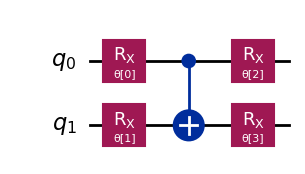

In [58]:
ansatz = EfficientSU2(H.num_qubits, su2_gates=["rx"], entanglement="linear", reps=1)
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(ansatz.decompose().depth())
ansatz.decompose().draw("mpl")

In [60]:
def cost_func(params, ansatz, H, estimator):
    pub = (ansatz, [H], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    return energy
 
 
# def cost_func_sim(params, ansatz, H, estimator):
#    energy = estimator.run(ansatz, H, parameter_values=params).result().values[0]
#    return energy

In [64]:
# We will start by using a local simulator
from qiskit_aer import AerSimulator
 
# Import an estimator, this time from qiskit (we will import from Runtime for real hardware)
from qiskit.primitives import BackendEstimatorV2
 
# generate a simulator that mimics the real quantum system
backend_sim = AerSimulator.from_backend("BackendV2")
estimator = BackendEstimatorV2(backend=backend_sim)

TypeError: The backend argument requires a BackendV2 or BackendV1 object, not a <class 'str'> object